# 사전작업

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 150)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

## 데이터 로드

In [3]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 8min 13s


## train, test 합치기

In [5]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194754

## Get Date - AvSigVersion

In [6]:
datedict = np.load('./data/AvSigVersionTimestamps.npy')
datedict = datedict[()]
data['Date'] = data['AvSigVersion'].map(datedict)
data['Date_YMD'] = pd.to_datetime(data['Date'].astype(str).str.slice(0, 10))
del datedict

## 2018년 1월 1일 ~ 9월 24일

### Data Load

In [7]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

In [8]:
lb_692 = pd.read_csv('./data/submission_lgb.csv')
lb_692['Date_YMD'] = test.Date_YMD.values

In [9]:
lb_701 = pd.read_csv('./data/YH_v3_new_jebal.csv')
lb_701['Date_YMD'] = test.Date_YMD.values

In [10]:
lb_702 = pd.read_csv('./data/time_test.csv')
lb_702['Date_YMD'] = test.Date_YMD.values

In [11]:
lb_694 = pd.read_csv('./data/time_test_3.csv')
lb_694['Date_YMD'] = test.Date_YMD.values

In [12]:
lb_706 = pd.read_csv('./data/time_test_5.csv')
lb_706['Date_YMD'] = test.Date_YMD.values

In [13]:
lb_707 = pd.read_csv('./data/time_test_7.csv')
lb_707['Date_YMD'] = test.Date_YMD.values

In [14]:
time_un = pd.read_csv('./data/submission_lgb_drop_time_related_feature.csv')
time_un['Date_YMD'] = test.Date_YMD.values

In [15]:
time_un2 = pd.read_csv('./data/sub_lgb_without_time.csv')
time_un2['Date_YMD'] = test.Date_YMD.values

In [16]:
group = pd.read_csv('./data/groupby_date.csv').sort_values('MachineIdentifier')
group['Date_YMD'] = test.Date_YMD.values

In [17]:
group_t_isprotected = pd.read_csv('./data/groupby_date_t_t_isprotected.csv').sort_values('MachineIdentifier')
group_t_isprotected['Date_YMD'] = test.Date_YMD.values

In [18]:
group_t = pd.read_csv('./data/groupby_date_t_t.csv').sort_values('MachineIdentifier')
group_t['Date_YMD'] = test.Date_YMD.values

In [68]:
yh = pd.read_csv('./data/blending2.csv').sort_values('MachineIdentifier')
yh['Date_YMD'] = test.Date_YMD.values

In [71]:
final = pd.read_csv('./data/final.csv')
final['Date_YMD'] = test.Date_YMD.values

### make meta

In [20]:
time_idx = data.groupby(['Date_YMD']).size().index

In [21]:
temp = pd.DataFrame(time_idx)

In [22]:
condition = (temp.Date_YMD >= '2018-01-01')&(temp.Date_YMD <= '2018-11-25')

### train, test

In [23]:
tr_temp = train.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()
te_temp = test.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [24]:
tr_temp = temp.merge(tr_temp, on='Date_YMD', how='left')
te_temp = temp.merge(te_temp, on='Date_YMD', how='left')

In [25]:
tr_temp = tr_temp[condition]
te_temp = te_temp[condition]

### lb_692

In [26]:
lb_temp_692 = lb_692.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [27]:
lb_temp_692 = temp.merge(lb_temp_692, on='Date_YMD', how='left')

In [28]:
lb_temp_692 = lb_temp_692[condition]

### lb_694

In [29]:
lb_temp_694 = lb_694.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [30]:
lb_temp_694 = temp.merge(lb_temp_694, on='Date_YMD', how='left')

In [31]:
lb_temp_694 = lb_temp_694[condition]

### lb_701

In [32]:
lb_temp_701 = lb_701.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [33]:
lb_temp_701 = temp.merge(lb_temp_701, on='Date_YMD', how='left')

In [34]:
lb_temp_701 = lb_temp_701[condition]

### lb_702

In [35]:
lb_temp_702 = lb_702.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [36]:
lb_temp_702 = temp.merge(lb_temp_702, on='Date_YMD', how='left')

In [37]:
lb_temp_702 = lb_temp_702[condition]

### lb_706

In [38]:
lb_temp_706 = lb_706.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [39]:
lb_temp_706 = temp.merge(lb_temp_706, on='Date_YMD', how='left')

In [40]:
lb_temp_706 = lb_temp_706[condition]

### lb_707

In [41]:
lb_temp_707 = lb_707.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [42]:
lb_temp_707 = temp.merge(lb_temp_707, on='Date_YMD', how='left')

In [43]:
lb_temp_707 = lb_temp_707[condition]

### time unrelated

In [44]:
time_un_temp = time_un.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [45]:
time_un_temp = temp.merge(time_un_temp, on='Date_YMD', how='left')

In [46]:
time_un_temp = time_un_temp[condition]

### time unrelated 2

In [47]:
time_un2_temp = time_un2.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [48]:
time_un2_temp = temp.merge(time_un2_temp, on='Date_YMD', how='left')

In [49]:
time_un2_temp = time_un2_temp[condition]

### group

In [50]:
group_temp = group.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [51]:
group_temp = temp.merge(group_temp, on='Date_YMD', how='left')

In [52]:
group_temp = group_temp[condition]

### group_t_is_protected

In [53]:
group__t_isprotected_temp = group_t_isprotected.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [54]:
group__t_isprotected_temp = temp.merge(group__t_isprotected_temp, on='Date_YMD', how='left')

In [55]:
group__t_isprotected_temp = group__t_isprotected_temp[condition]

### group_t

In [56]:
group_t_temp = group_t.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [57]:
group_t_temp = temp.merge(group_t_temp, on='Date_YMD', how='left')

In [58]:
group_t_temp = group_t_temp[condition]

### yh

In [59]:
yh_temp = yh.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [60]:
yh_temp = temp.merge(yh_temp, on='Date_YMD', how='left')

In [61]:
yh_temp = yh_temp[condition]

### final

In [74]:
final_temp = final.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [75]:
final_temp = temp.merge(final_temp, on='Date_YMD', how='left')

In [76]:
final_temp = final_temp[condition]

### hypothesis

In [77]:
# hypothesis_temp = train.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [78]:
# hypothesis_temp.Date_YMD = hypothesis_temp.Date_YMD + pd.offsets.MonthOffset(2)

In [79]:
# condition_H = (hypothesis_temp.Date_YMD >= '2018-01-01')&(hypothesis_temp.Date_YMD <= '2018-11-25')
# hypothesis_temp = hypothesis_temp[condition_H]

In [80]:
# hypothesis_temp = temp.merge(hypothesis_temp, on='Date_YMD', how='left')

### test

### check hypothesis

In [161]:
check_temp = check.groupby(['Date_YMD']).HasDetections.agg(['size', 'mean']).reset_index()
condition_c = (check_temp.Date_YMD >= '2018-01-01')&(check_temp.Date_YMD <= '2018-11-25')
check_temp = check_temp[condition_c]

### plot

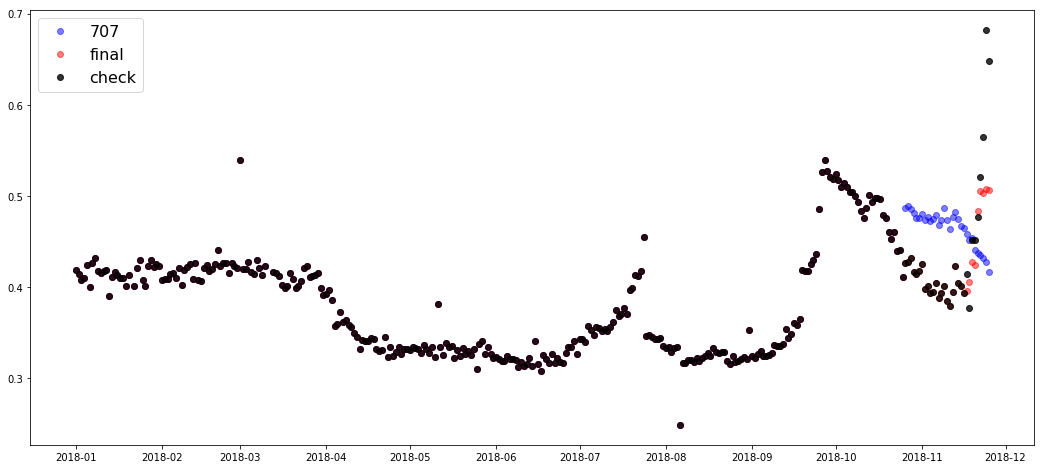

In [162]:
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date_YMD, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.plot(lb_temp_701.Date_YMD, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date_YMD, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date_YMD, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=0.5, label='707')
# plt.plot(group__t_isprotected_temp.Date_YMD, group__t_isprotected_temp['mean'], 'o', color='r', alpha=1, label='group_t_is_protected')
# plt.plot(group_t_temp.Date_YMD, group_t_temp['mean'], 'o', color='y', alpha=1, label='group_t')
# plt.plot(yh_temp.Date_YMD, yh_temp['mean'], 'o', color='b', alpha=1, label='yh')
# plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='k', alpha=0.3, label='un time - 686')
# plt.plot(time_un2_temp.Date_YMD, time_un2_temp['mean'], 'o', color='r', alpha=0.3, label='un time - 683')
# plt.plot(group_temp.Date_YMD, group_temp['mean'], 'o', color='r', alpha=1, label='groupby')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.35 / 178909) + 0.3, 'og', label='guide')
plt.plot(final_temp.Date_YMD, final_temp['mean'], 'o', color='r', alpha=0.5, label='final')

plt.plot(check_temp.Date_YMD, check_temp['mean'], 'o', color='k', alpha=0.8, label='check')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.3 / 178909) + 0.3, 'ok', label='guide')
# plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['mean'], '+', color='c', alpha=1, label='hypothesis')
plt.legend(prop={'size': 16})

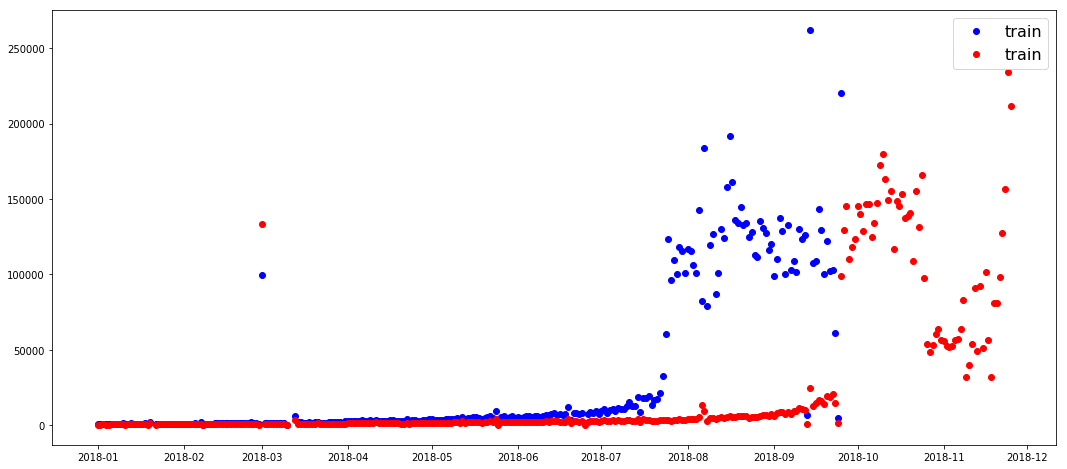

In [97]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], 'o', color='b', alpha=1, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], 'o', color='r', alpha=1, label='train')
# plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['size'], 'o', color='c', alpha=1, label='train')
plt.legend(prop={'size': 16})

## 데이터 개수 곱해버리기

In [144]:
te_temp['new_size'] = (te_temp['size'] - 657) * (0.27 / 178909) + 0.33

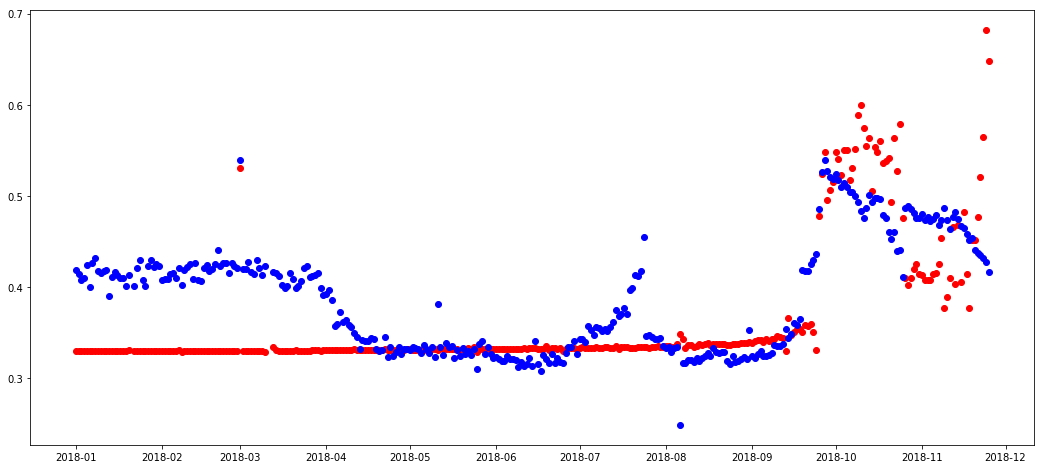

In [145]:
# 최저가 0.3, 최고가 0.6
plt.figure(figsize=(18, 8))
plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.27 / 178909) + 0.33, 'or')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')

In [146]:
te_temp['rate'] = te_temp.new_size / final_temp['mean']

In [147]:
lb_707_new = final.merge(te_temp, on='Date_YMD', how='left').fillna(1)

In [148]:
final['NewHasDetections'] = lb_707_new.HasDetections * lb_707_new.rate

In [149]:
t = final[['MachineIdentifier', 'NewHasDetections', 'Date_YMD']]

In [150]:
t.columns = ['MachineIdentifier', 'HasDetections', 'Date_YMD']

In [151]:
t_temp = t.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [152]:
t_temp = temp.merge(t_temp, on='Date_YMD', how='left')

In [153]:
t_temp = t_temp[condition]

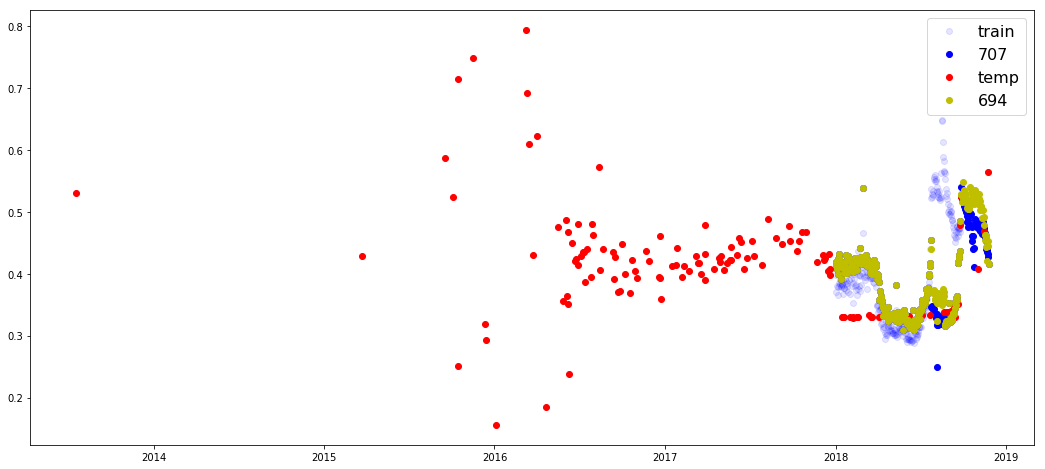

In [154]:
# 최저가 0.3, 최고가 0.6
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(lb_temp_707_new.Date_YMD, lb_temp_707_new['mean'], 'o', color='r', alpha=1, label='707_new')
plt.plot(t_temp.Date_YMD, t_temp['mean'], 'o', color='r', alpha=1, label='temp')
plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
plt.legend(prop={'size': 16})

In [155]:
test = test.reset_index(drop=True)

In [157]:
condition = test.Date_YMD >= '2018-11-17'

In [158]:
change = final[condition]
not_change = final[~condition]

In [159]:
change.HasDetections = change.NewHasDetections

In [160]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [165]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/finax.csv', index=False)

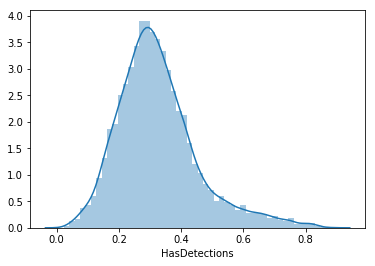

In [259]:
sns.distplot(lb_707[lb_707.Date_YMD == '2018-09-01'].HasDetections)

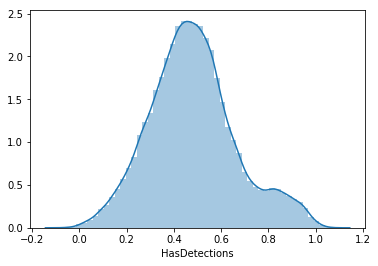

In [261]:
sns.distplot(lb_707[lb_707.Date_YMD == '2018-11-01'].HasDetections)

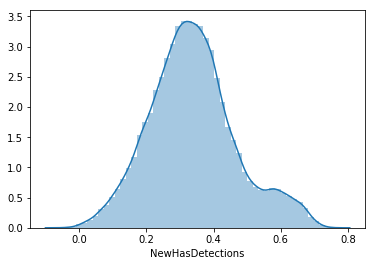

In [260]:
sns.distplot(lb_707[lb_707.Date_YMD == '2018-11-01'].NewHasDetections)

In [111]:
def get_has_detections(data):
    try:
        if data.Date_YMD == '2018-10-25':
            return data.HasDetections * 0.8932461873638343
        elif data.Date_YMD == '2018-10-24':
            return data.HasDetections *  0.946000733633222
        elif data.Date_YMD == '2018-10-23':
            return data.HasDetections *  0.9557970983024938
        elif data.Date_YMD == '2018-10-22':
            return data.HasDetections * 0.9655259079294601
        elif data.Date_YMD == '2018-10-21':
            return data.HasDetections * 0.9681535196547988
        elif data.Date_YMD == '2018-10-20':
            return data.HasDetections * 0.9655259079294601
        else:
            return data.HasDetections
    except:
        print(data)

In [176]:
t1 = lb_707[lb_707.Date_YMD == '2018-10-25']
t2 = lb_707[lb_707.Date_YMD == '2018-10-24']
t3 = lb_707[lb_707.Date_YMD == '2018-10-23']
t4 = lb_707[lb_707.Date_YMD == '2018-10-22']
t5 = lb_707[lb_707.Date_YMD == '2018-10-21']
t6 = lb_707[lb_707.Date_YMD == '2018-10-20']
t7 = lb_707[~((lb_707.Date_YMD == '2018-10-25') | (lb_707.Date_YMD == '2018-10-24') | (lb_707.Date_YMD == '2018-10-23') | (lb_707.Date_YMD == '2018-10-22')| (lb_707.Date_YMD == '2018-10-21') | (lb_707.Date_YMD == '2018-10-20'))]

In [177]:
t1.HasDetections = t1.HasDetections * 0.8732461873638343
t2.HasDetections = t2.HasDetections * 0.926000733633222
t3.HasDetections = t3.HasDetections * 0.9457970983024938
t4.HasDetections = t4.HasDetections * 0.9555259079294601
t5.HasDetections = t5.HasDetections * 0.9581535196547988
t6.HasDetections = t6.HasDetections * 0.9555259079294601

In [178]:
temp2 = t1.append(t2).append(t3).append(t4).append(t5).append(t6).append(t7).sort_values('MachineIdentifier').reset_index(drop=True)

In [182]:
temp2_temp = temp2.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [183]:
temp2_temp = temp.merge(temp2_temp, on='Date_YMD', how='left')

In [188]:
temp2_temp = temp2_temp[condition]

NameError: name 'temp2_temp' is not defined

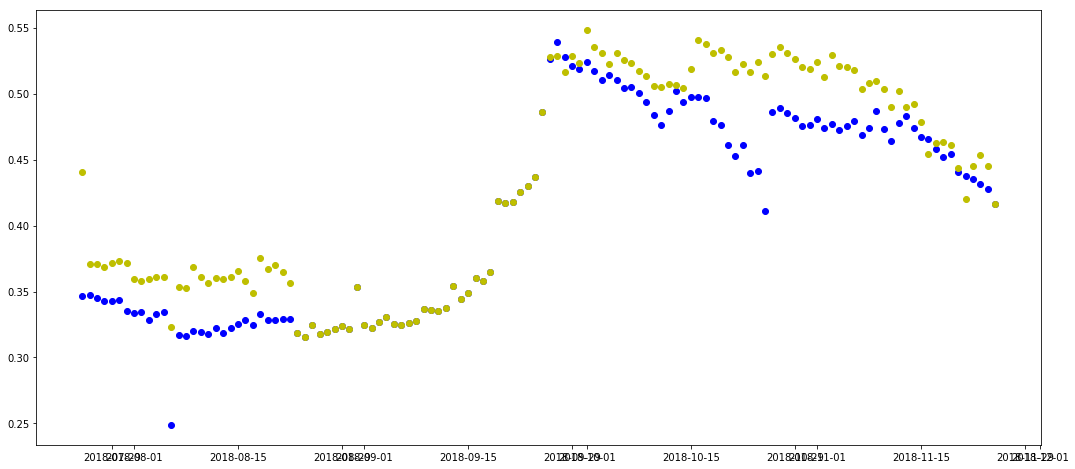

In [265]:
# 최저가 0.3, 최고가 0.6
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(lb_temp_707_new.Date_YMD, lb_temp_707_new['mean'], 'o', color='r', alpha=1, label='707_new')
plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
plt.plot(temp2_temp.Date_YMD, temp2_temp['mean'], 'o', color='g', alpha=1, label='new')
plt.legend(prop={'size': 16})

In [197]:
temp2[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_11.csv', index=False)

##### 회귀

In [3]:
x = np.array(list(range(te_temp.shape[0])))[:, np.newaxis]
y = te_temp['size'].values.tolist()

NameError: name 'np' is not defined

In [341]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [349]:
lr = LinearRegression()
pr = LinearRegression()

In [398]:
quadratic = PolynomialFeatures(degree=12)
X_quad = quadratic.fit_transform(x)

In [399]:
pr.fit(X_quad, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [400]:
y_quad_fit = pr.predict(X_quad)

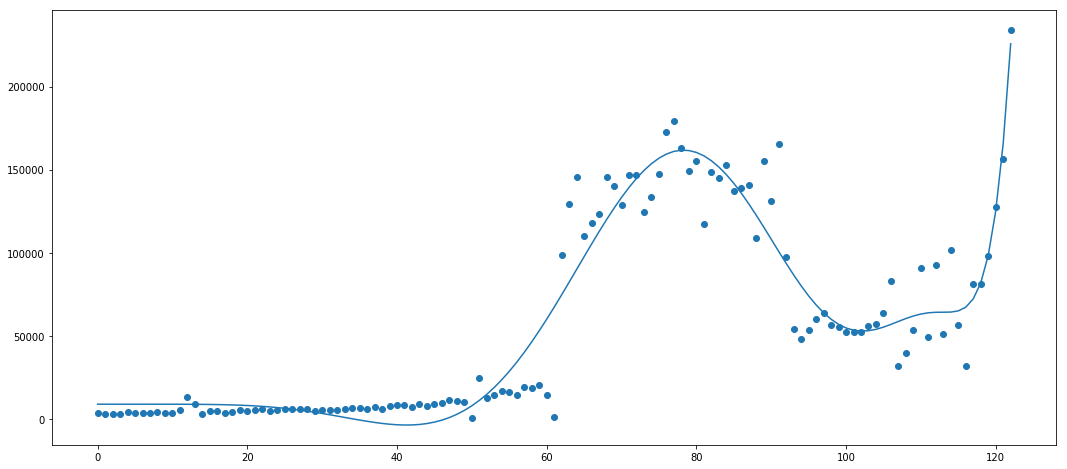

In [401]:
plt.figure(figsize=(18,8))
plt.scatter(x, y)
plt.plot(y_quad_fit)

## 707을 7월 25일부터 9월 14일까지

In [257]:
change = lb_707[(lb_707.Date_YMD >= '2018-7-25') & (lb_707.Date_YMD <= '2018-9-14')]
not_change = lb_707[~((lb_707.Date_YMD >= '2018-07-25') & (lb_707.Date_YMD <= '2018-9-14'))]

In [258]:
change.HasDetections = yh[(yh.Date_YMD >= '2018-7-25') & (yh.Date_YMD <= '2018-9-14')].HasDetections * 0.3 + change.HasDetections * 0.7

In [259]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [262]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_13.csv', index=False)

## 707을 9월 25일부터 10월 14일까지

In [271]:
change = lb_707[(lb_707.Date_YMD >= '2018-09-25') & (lb_707.Date_YMD <= '2018-10-14')]
not_change = lb_707[~((lb_707.Date_YMD >= '2018-09-25') & (lb_707.Date_YMD <= '2018-10-14'))]

In [272]:
test = lb_707[(lb_707.Date_YMD >= '2018-09-25') & (lb_707.Date_YMD <= '2018-10-14')]

In [273]:
change.HasDetections = test.NewHasDetections.values

In [274]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [282]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_12.csv', index=False)

## 707을 9월 30일부터 10월 14일까지

In [301]:
change = lb_707[(lb_707.Date_YMD >= '2018-09-30') & (lb_707.Date_YMD <= '2018-10-14')]
not_change = lb_707[~((lb_707.Date_YMD >= '2018-09-30') & (lb_707.Date_YMD <= '2018-10-14'))]

In [302]:
test = lb_707[(lb_707.Date_YMD >= '2018-09-30') & (lb_707.Date_YMD <= '2018-10-14')]

In [304]:
change.HasDetections = (test.NewHasDetections.values + change.HasDetections) / 2

In [310]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [311]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_9.csv', index=False)

## 706에서 8월 22일까지를 cat으로 바꿔보기

In [285]:
change = lb_706[(lb_706.Date_YMD >= '2018-07-25') & (lb_706.Date_YMD <= '2018-08-22')]
not_change = lb_706[~((lb_706.Date_YMD >= '2018-07-25') & (lb_706.Date_YMD <= '2018-08-22'))]

In [288]:
test = lb_707[(lb_707.Date_YMD >= '2018-07-25') & (lb_707.Date_YMD <= '2018-08-22')]

In [289]:
change.HasDetections = test.NewHasDetections.values

In [290]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [298]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_8.csv', index=False)

## 706에서 9월 26일부터 11월 25일까지 Hypothesis Check으로 바꿔보기

In [162]:
change = lb_707[(lb_707.Date_YMD >= '2018-09-26') & (lb_707.Date_YMD <= '2018-11-25')]
not_change = lb_707[~((lb_707.Date_YMD >= '2018-09-26') & (lb_707.Date_YMD <= '2018-11-25'))]

In [163]:
change.HasDetections = lgb_test_result / 3

In [164]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [122]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_4.csv', index=False)

# Crazy Method - 2달 미뤄서 훈련시켜보기 1

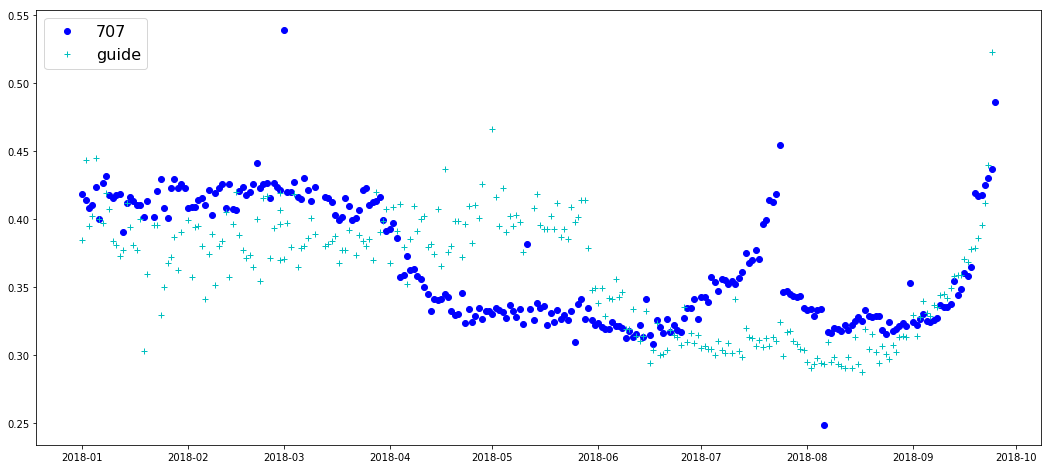

In [447]:
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date_YMD, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.plot(lb_temp_701.Date_YMD, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date_YMD, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date_YMD, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='k', alpha=1, label='un time')
# plt.plot(group_temp.Date_YMD, group_temp['mean'], 'o', color='r', alpha=1, label='groupby')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.35 / 178909) + 0.3, 'og', label='guide')

# plt.plot(check_temp.Date_YMD, check_temp['mean'], 'o', color='k', alpha=0.5, label='check')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.3 / 178909) + 0.3, 'or')
plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['mean'], '+', color='c', alpha=1, label='guide')
plt.legend(prop={'size': 16})

* Train 2018년 1월 24일 ~ 2018년 3월 24일
* Test 2018년 3월 24일 ~ 2018년 5월 24일

In [654]:
t = data[(data.Date_YMD >= '2018-03-24') & (data.Date_YMD <= '2018-09-24') & (data.Date_YMD != '2018-03-01')]
del t['Date']
gc.collect()

7

In [655]:
train = t[~t.HasDetections.isna()]
test = t[t.HasDetections.isna()]

del t
gc.collect()

7

In [656]:
train = train[train.Date_YMD <= '2018-07-24']
test = test[test.Date_YMD >= '2018-05-24']

gc.collect()

0

In [657]:
# 2달 미루기
train.Date_YMD = train.Date_YMD + pd.offsets.MonthOffset(2)

In [658]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [659]:
train.shape

(848596, 84)

In [660]:
test.shape

(648843, 84)

In [661]:
# train.Date_YMD.value_counts().sort_index()

In [662]:
del train['AvSigVersion'], test['AvSigVersion']
gc.collect()

7

In [663]:
#1 27
#2 10

In [664]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 100)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total']) > 0.2) & (agg['Train'] / (agg['Total']) < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [665]:
train.shape

(848596, 83)

In [666]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [667]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

28

In [668]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [669]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [670]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [671]:
train.shape

(848596, 7239)

In [672]:
test.shape

(648843, 7239)

In [673]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [674]:
del ohe, train, test
gc.collect()

1148

In [675]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [676]:
train.shape

(848596, 7239)

In [677]:
test.shape

(648843, 7239)

In [678]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [679]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.67525	valid_0's binary_logloss: 0.600339
[200]	valid_0's auc: 0.683175	valid_0's binary_logloss: 0.595639
[300]	valid_0's auc: 0.685624	valid_0's binary_logloss: 0.594195
[400]	valid_0's auc: 0.686644	valid_0's binary_logloss: 0.593592
[500]	valid_0's auc: 0.687237	valid_0's binary_logloss: 0.593235
[600]	valid_0's auc: 0.687691	valid_0's binary_logloss: 0.592946
[700]	valid_0's auc: 0.688021	valid_0's binary_logloss: 0.592736
[800]	valid_0's auc: 0.688288	valid_0's binary_logloss: 0.592562
[900]	valid_0's auc: 0.688537	valid_0's binary_logloss: 0.592408
[1000]	valid_0's auc: 0.688733	valid_0's binary_logloss: 0.592279
[1100]	valid_0's auc: 0.68883	valid_0's binary_logloss: 0.592204
[1200]	valid_0's auc: 0.688964	valid_0's binary_logloss: 0.592127
[1300]	valid_0's auc: 0.689019	valid_0's binary_logloss: 0.592072
[1400]	valid_0's auc: 0.689092	valid_0's binary_logloss: 0.5920

In [680]:
lgb_test_result/3

array([0.40469891, 0.40093989, 0.18747329, ..., 0.2869779 , 0.43773369,
       0.4879009 ])

In [681]:
change = lb_707[(lb_707.Date_YMD >= '2018-05-24') & (lb_707.Date_YMD <= '2018-09-24')]
not_change = lb_707[~((lb_707.Date_YMD >= '2018-05-24') & (lb_707.Date_YMD <= '2018-09-24'))]

In [682]:
change.shape, lgb_test_result.shape

((648843, 3), (648843,))

In [683]:
change.HasDetections = lgb_test_result / 3

In [684]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [685]:
check_temp = check.groupby(['Date_YMD']).HasDetections.agg(['size', 'mean']).reset_index()
condition_c = (check_temp.Date_YMD >= '2018-01-21')&(check_temp.Date_YMD <= '2018-09-24')
check_temp = check_temp[condition_c]

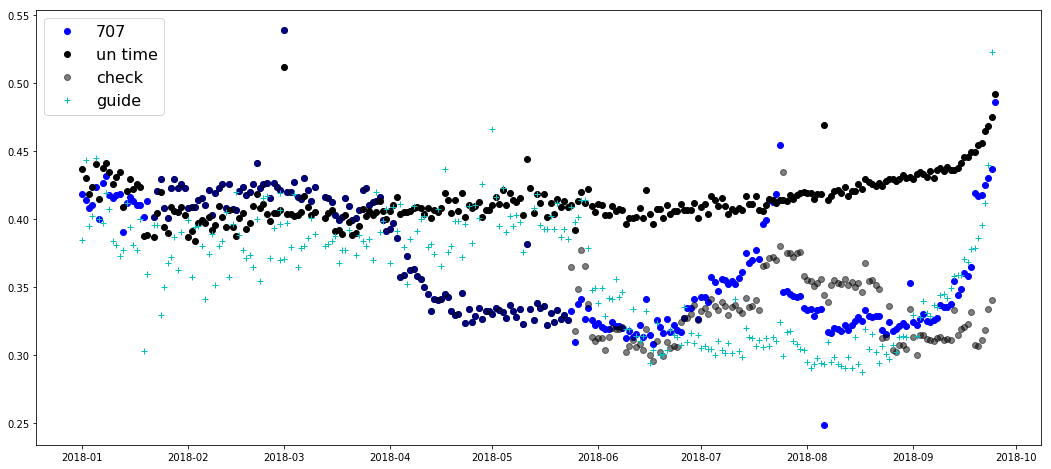

In [688]:
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date_YMD, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.plot(lb_temp_701.Date_YMD, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date_YMD, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date_YMD, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='k', alpha=1, label='un time')
# plt.plot(group_temp.Date_YMD, group_temp['mean'], 'o', color='r', alpha=1, label='groupby')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.35 / 178909) + 0.3, 'og', label='guide')

plt.plot(check_temp.Date_YMD, check_temp['mean'], 'o', color='k', alpha=0.5, label='check')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.3 / 178909) + 0.3, 'or')
plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['mean'], '+', color='c', alpha=1, label='guide')
plt.legend(prop={'size': 16})

* Train 2018년 3월 24일 ~ 2018년 5월 24일
* Test 2018년 5월 24일 ~ 2018년 7월 24일

In [586]:
t = data[(data.Date_YMD >= '2018-03-24') & (data.Date_YMD <= '2018-07-24')]
del t['Date']
gc.collect()

0

In [587]:
train = t[~t.HasDetections.isna()]
test = t[t.HasDetections.isna()]

del t
gc.collect()

7

In [588]:
train = train[train.Date_YMD <= '2018-05-24']
test = test[test.Date_YMD >= '2018-05-24']

gc.collect()

0

In [589]:
# 2달 미루기
train.Date_YMD = train.Date_YMD + pd.offsets.MonthOffset(2)

In [590]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [591]:
train.shape

(221297, 84)

In [592]:
test.shape

(165564, 84)

In [593]:
# train.Date_YMD.value_counts().sort_index()

In [594]:
del train['AvSigVersion'], test['AvSigVersion']
gc.collect()

7

In [595]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 27)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total']) > 0.2) & (agg['Train'] / (agg['Total']) < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [596]:
train.shape

(221297, 83)

In [597]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [598]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

28

In [599]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [600]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [601]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [602]:
train.shape

(221297, 6953)

In [603]:
test.shape

(165564, 6953)

In [604]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [605]:
del ohe, train, test
gc.collect()

1148

In [606]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [607]:
train.shape

(221297, 6953)

In [608]:
test.shape

(165564, 6953)

In [609]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [610]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.668785	valid_0's binary_logloss: 0.584955
[200]	valid_0's auc: 0.672469	valid_0's binary_logloss: 0.582787
[300]	valid_0's auc: 0.673592	valid_0's binary_logloss: 0.582089
[400]	valid_0's auc: 0.673665	valid_0's binary_logloss: 0.581929
[500]	valid_0's auc: 0.673491	valid_0's binary_logloss: 0.581965
Early stopping, best iteration is:
[437]	valid_0's auc: 0.673787	valid_0's binary_logloss: 0.581876
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.668633	valid_0's binary_logloss: 0.58543
[200]	valid_0's auc: 0.671839	valid_0's binary_logloss: 0.583272
[300]	valid_0's auc: 0.672452	valid_0's binary_logloss: 0.582736
[400]	valid_0's auc: 0.672422	valid_0's binary_logloss: 0.582522
Early stopping, best iteration is:
[358]	valid_0's auc: 0.672543	valid_0's binary_logloss: 0.582562
predicting
Fold 3

fitting
Training 

In [611]:
lgb_test_result/3

array([0.39567669, 0.26128841, 0.32241715, ..., 0.22979366, 0.25901553,
       0.55169986])

In [614]:
change = check[(check.Date_YMD >= '2018-05-24') & (check.Date_YMD <= '2018-07-24')]
not_change = check[~((check.Date_YMD >= '2018-05-24') & (check.Date_YMD <= '2018-07-24'))]

In [615]:
change.shape, lgb_test_result.shape

((165564, 3), (165564,))

In [616]:
change.HasDetections = lgb_test_result / 3

In [641]:
check2 = change.append(not_change).sort_values('MachineIdentifier')

In [643]:
check2_temp = check2.groupby(['Date_YMD']).HasDetections.agg(['size', 'mean']).reset_index()
condition_c = (check2_temp.Date_YMD >= '2018-01-21')&(check2_temp.Date_YMD <= '2018-09-24')
check2_temp = check2_temp[condition_c]

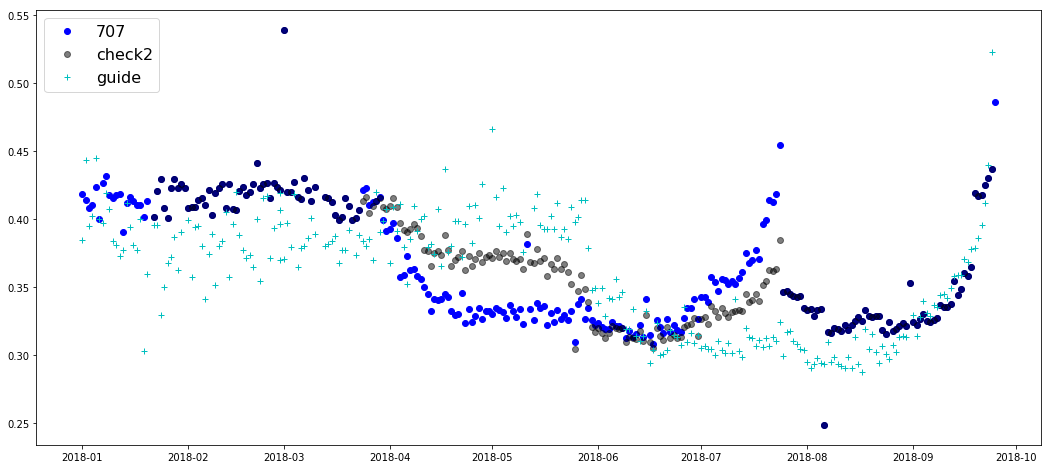

In [644]:
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date_YMD, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.plot(lb_temp_701.Date_YMD, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date_YMD, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date_YMD, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='k', alpha=1, label='un time')
# plt.plot(group_temp.Date_YMD, group_temp['mean'], 'o', color='r', alpha=1, label='groupby')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.35 / 178909) + 0.3, 'og', label='guide')

# plt.plot(check_temp.Date_YMD, check_temp['mean'], 'o', color='k', alpha=0.2, label='check')
plt.plot(check2_temp.Date_YMD, check2_temp['mean'], 'o', color='k', alpha=0.5, label='check2')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.3 / 178909) + 0.3, 'or')
plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['mean'], '+', color='c', alpha=1, label='guide')
plt.legend(prop={'size': 16})

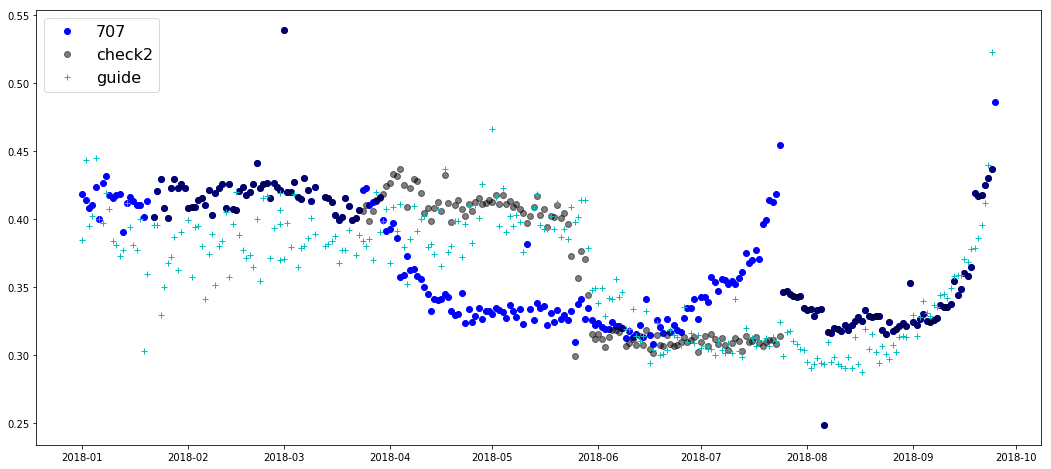

In [623]:
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date_YMD, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.plot(lb_temp_701.Date_YMD, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date_YMD, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date_YMD, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='k', alpha=1, label='un time')
# plt.plot(group_temp.Date_YMD, group_temp['mean'], 'o', color='r', alpha=1, label='groupby')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.35 / 178909) + 0.3, 'og', label='guide')

# plt.plot(check_temp.Date_YMD, check_temp['mean'], 'o', color='k', alpha=0.2, label='check')
plt.plot(check2_temp.Date_YMD, check2_temp['mean'], 'o', color='k', alpha=0.5, label='check2')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.3 / 178909) + 0.3, 'or')
plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['mean'], '+', color='c', alpha=1, label='guide')
plt.legend(prop={'size': 16})

In [628]:
check2

,MachineIdentifier,HasDetections,Date_YMD
0,0000010489e3af074adeac69c53e555e,0.506743,2018-11-20
1,00000176ac758d54827acd545b6315a5,0.515043,2018-10-22
2,0000019dcefc128c2d4387c1273dae1d,0.611486,2018-09-28
3,0000055553dc51b1295785415f1a224d,0.342288,2018-11-23
4,00000574cefffeca83ec8adf9285b2bf,0.465092,2018-10-21
5,000007ffedd31948f08e6c16da31f6d1,0.506531,2018-10-07
6,000008f31610018d898e5f315cdf1bd1,0.247400,2018-11-07
7,00000a3c447250626dbcc628c9cbc460,0.207781,2018-10-16
8,00000b6bf217ec9aef0f68d5c6705897,0.185144,2018-11-23
9,00000b8d3776b13e93ad83676a28e4aa,0.530368,2018-04-15


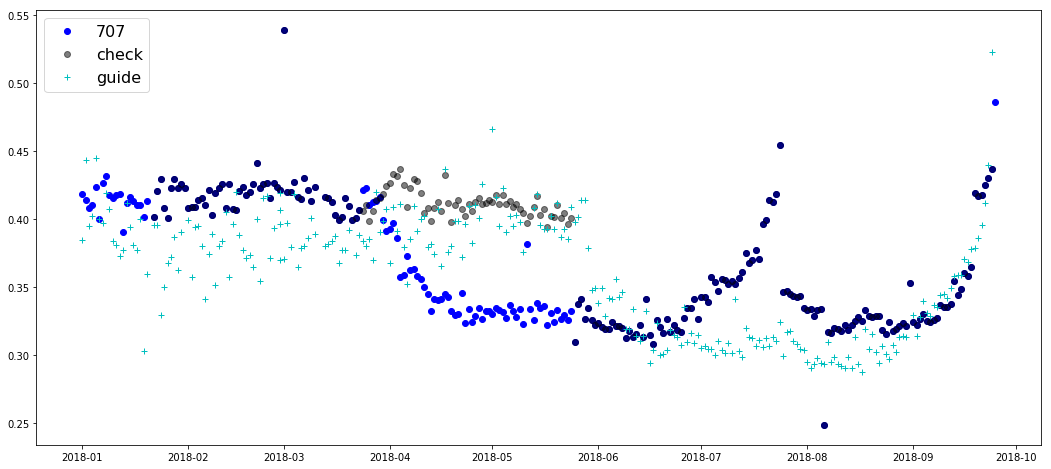

In [622]:
plt.figure(figsize=(18, 8))
# plt.plot(tr_temp.Date_YMD, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date_YMD, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_694.Date_YMD, lb_temp_694['mean'], 'o', color='y', alpha=1, label='694')
# plt.plot(lb_temp_701.Date_YMD, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date_YMD, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date_YMD, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date_YMD, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(time_un_temp.Date_YMD, time_un_temp['mean'], 'o', color='k', alpha=1, label='un time')
# plt.plot(group_temp.Date_YMD, group_temp['mean'], 'o', color='r', alpha=1, label='groupby')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.35 / 178909) + 0.3, 'og', label='guide')

plt.plot(check_temp.Date_YMD, check_temp['mean'], 'o', color='k', alpha=0.5, label='check')
# plt.plot(te_temp.Date_YMD, (te_temp['size'] - 657) * (0.3 / 178909) + 0.3, 'or')
plt.plot(hypothesis_temp.Date_YMD, hypothesis_temp['mean'], '+', color='c', alpha=1, label='guide')
plt.legend(prop={'size': 16})

In [631]:
t = lb_707.HasDetections.to_frame()

In [633]:
t['new'] = check2.HasDetections

In [642]:
check2.HasDetections = check2.HasDetections * 0.5 + lb_707.HasDetections * 0.5

In [645]:
check2[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_15.csv', index=False)

# Crazy Method - 2달 미뤄서 훈련시켜보기 2

In [43]:
temp = data[(data.Date_YMD >= '2018-05-25') & (data.Date_YMD <= '2018-09-24')]
del temp['Date']
gc.collect()

33

In [44]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

del temp
gc.collect()

14

In [45]:
train = train[train.Date_YMD <= '2018-07-24']
test = test[test.Date_YMD >= '2018-07-25']

gc.collect()

0

In [46]:
# 2달 미루기
train.Date_YMD = train.Date_YMD + pd.offsets.MonthOffset(2)

In [47]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [48]:
train.shape

(627299, 84)

In [49]:
test.shape

(483279, 84)

In [225]:
del train['AvSigVersion'], test['AvSigVersion']
gc.collect()

7

In [231]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 50)].reset_index(drop=True)
    agg['Total'] = agg['Train'] / 3 + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total'] * 3) > 0.14) & (agg['Train'] / (agg['Total'] * 3) < 0.86)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [232]:
train.shape

(627299, 84)

In [233]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [234]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

21

In [235]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [236]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [237]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [238]:
train.shape

(627299, 10039)

In [239]:
test.shape

(161697, 10039)

In [240]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [241]:
del ohe, train, test
gc.collect()

1162

In [242]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [243]:
train.shape

(627299, 10039)

In [244]:
test.shape

(161697, 10039)

In [246]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [247]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.677371	valid_0's binary_logloss: 0.604701
[200]	valid_0's auc: 0.685048	valid_0's binary_logloss: 0.599969
[300]	valid_0's auc: 0.687145	valid_0's binary_logloss: 0.598676
[400]	valid_0's auc: 0.687966	valid_0's binary_logloss: 0.598151
[500]	valid_0's auc: 0.688526	valid_0's binary_logloss: 0.59779
[600]	valid_0's auc: 0.688837	valid_0's binary_logloss: 0.597577
[700]	valid_0's auc: 0.689194	valid_0's binary_logloss: 0.597344
[800]	valid_0's auc: 0.68942	valid_0's binary_logloss: 0.597182
[900]	valid_0's auc: 0.689547	valid_0's binary_logloss: 0.597075
[1000]	valid_0's auc: 0.689621	valid_0's binary_logloss: 0.596991
[1100]	valid_0's auc: 0.68967	valid_0's binary_logloss: 0.596924
[1200]	valid_0's auc: 0.689712	valid_0's binary_logloss: 0.596872
[1300]	valid_0's auc: 0.689751	valid_0's binary_logloss: 0.596838
[1400]	valid_0's auc: 0.689791	valid_0's binary_logloss: 0.59680

# Crazy Method - 4달 미뤄서 훈련시켜보기

In [112]:
temp = data[(data.Date_YMD >= '2018-05-26') & (data.Date_YMD <= '2018-11-25')]
del temp['Date']
gc.collect()

8

In [113]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

del temp
gc.collect()

14

In [114]:
train = train[train.Date_YMD <= '2018-07-25']
test = test[test.Date_YMD >= '2018-09-26']

gc.collect()

0

In [115]:
# 2달 미루기
train.Date_YMD = train.Date_YMD + pd.offsets.MonthOffset(2)

In [116]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [117]:
train.shape

(749917, 84)

In [118]:
test.shape

(6598039, 84)

In [119]:
del train['AvSigVersion'], test['AvSigVersion']
gc.collect()

7

In [127]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 94)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test'] / 10
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total']) > 0.2) & (agg['Train'] / (agg['Total']) < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [128]:
train.shape

(749917, 83)

In [129]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [130]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

28

In [131]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [132]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [133]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [134]:
train.shape

(749917, 6651)

In [135]:
test.shape

(6598039, 6651)

In [136]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [137]:
del ohe, train, test
gc.collect()

1148

In [138]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [139]:
train.shape

(749917, 6651)

In [140]:
test.shape

(6598039, 6651)

In [141]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [142]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.674795	valid_0's binary_logloss: 0.620621
[200]	valid_0's auc: 0.681594	valid_0's binary_logloss: 0.616375
[300]	valid_0's auc: 0.683513	valid_0's binary_logloss: 0.615177
[400]	valid_0's auc: 0.684402	valid_0's binary_logloss: 0.614616
[500]	valid_0's auc: 0.684942	valid_0's binary_logloss: 0.614282
[600]	valid_0's auc: 0.685345	valid_0's binary_logloss: 0.614011
[700]	valid_0's auc: 0.685678	valid_0's binary_logloss: 0.613785
[800]	valid_0's auc: 0.685888	valid_0's binary_logloss: 0.613628
[900]	valid_0's auc: 0.686112	valid_0's binary_logloss: 0.613472
[1000]	valid_0's auc: 0.686285	valid_0's binary_logloss: 0.613357
[1100]	valid_0's auc: 0.686443	valid_0's binary_logloss: 0.613273
[1200]	valid_0's auc: 0.686614	valid_0's binary_logloss: 0.613137
[1300]	valid_0's auc: 0.686685	valid_0's binary_logloss: 0.613086
[1400]	valid_0's auc: 0.686819	valid_0's binary_logloss: 0.61

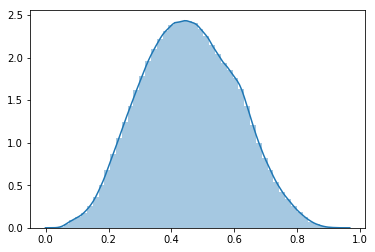

In [169]:
sns.distplot(lgb_test_result/3)

In [85]:
pd.DataFrame(lgb_test_result/3).to_csv('./data_temp/temp_11.csv')